# Exploring LAXPC data

The data you are going to explore is in a file labelled `laxpc_example.fits`.

We'll go through the data with the following steps:
1. Understanding the FITS file format
2. Understanding `EventList` and `Lightcurve` class from the stingray package
3. Loading the data from a fits file into an `EventList`
4. Making lightcurves at different timescales
5. Identifying a periodicity through a fourier transform
6. Folding the data at different harmonics

In [4]:
# import the necessary packages
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt


import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)

from scipy.fft import fft, fftshift # for Fourier transform
from scipy.signal import find_peaks
from astropy.io import fits # for fits file reading

from stingray.pulse.search import epoch_folding_search, z_n_search, plot_phaseogram, plot_profile
from stingray import EventList, Lightcurve, Powerspectrum
from stingray.pulse.pulsar import fold_events
from stingray.pulse.modeling import fit_sinc, fit_gaussian

/home/hbcse/Desktop/NIUS_Astronomy_workshop/x-ray/env/lib/python3.10/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/home/hbcse/Desktop/NIUS_Astronomy_workshop/x-ray/env/lib/python3.10/site-packages/stingray/utils.py:40: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


In [5]:
filename = "laxpc_example.fits"

## Load the fits file
A fits file consists of one of more `header data units` (HDUs). It is essentially a list of HDUs. Each HDU has a `header` which describes a detailed format of the data and any associated information (what target was observed, when was it observed, who was the astronomer observing it etc). The `data` section holds the information in the format specified in the `header`.

The astropy fits reader gives us easy access to explore the data. Use the `.info()` method to print out some information about the file.

1. How many HDUs does this file have? What are their names? How much information does each data unit have?

In [6]:
hdulist = fits.open(filename)

In [7]:
hdulist.info() #1,1 dimension= no data: 2 hdu 

Filename: laxpc_example.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   (1, 1)   int16   
  1  event file    1 BinTableHDU     51   13614384R x 5C   [1D, I2, I2, I2, 1E3.2]   


 Each HDU can be accessed with `[hdu_number]` or `['hdu_name']` and we can print the details of the header and data. Let us print the header for both the HDUs and see what we can understand. 
1. Can you find when this observation was taken?

In [8]:
hdulist[0].header #primary hdu, mjd-julian day reference time (integer and fractional) 

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                    1 / length of data axis 1                          
NAXIS2  =                    1 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
MISSION = 'ASTROSAT'                                                            
TELESCOP= 'ASTROSAT'                                                            
INSTRUME= 'LAXPC1  '                                                            
MJDREFI =                55197 / TDB time reference; Modified Julian Day (int)  
MJDREFF =                    0 / TDB time reference; Modified Julian Day (frac) 
TSTART  = 1.970990932224132E+08 / Elapsed seconds since MJDREF at start of file 
TSTOP   = 1.971966830604735E

RA DEC in degrees

In [9]:
hdulist[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   18 / width of table in bytes                        
NAXIS2  =             13614384 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5 / number of fields in each row                   
TTYPE1  = 'TIME    '           / Time elapsed since MJDREF                      
TFORM1  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 's       '           / physical unit of field                         
TTYPE2  = 'Channel '           / label for field   2                            
TFORM2  = 'I2      '        

t fields= number of columns
layers in laxpc
3 units of laxpc
channel isn counting number of electron which converts to energy but not linearly

tdb= barycenter (com of solarsystem)

1. Write a command to print the header in the second HDU. 
2. Describe the format of the table, number of rows in the table
3. What position in the sky was the telescope pointed (Look for RA and DEC)

In [10]:
hdulist[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   18 / width of table in bytes                        
NAXIS2  =             13614384 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5 / number of fields in each row                   
TTYPE1  = 'TIME    '           / Time elapsed since MJDREF                      
TFORM1  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 's       '           / physical unit of field                         
TTYPE2  = 'Channel '           / label for field   2                            
TFORM2  = 'I2      '        

Now, lets open up the data. We know it has 5 columns labelled `TIME`, `Channel`, `Layer`, `LAXPC_No`, `Energy`. 
1. `TIME`: Arrival time of the photon in seconds from a reference time (MJDREF).
2. `Channel`: The digital channel corresponding to energy of the photon (as an integer).
3. `Layer`: The layer of the LAXPC wires in which the photon was detected. Different layers have different noise vs signal properties. Some are more noisy than others. We won't worry about it in this observation. In general, Layer 1 has least noise, Layer 5 has most.
4. `LAXPC_No`: Which of the three LAXPC modules was the data gathered. All data in this observation comes from LAXPC No 1.  
5. `Energy`: Energy of the photon, converted from `Channel` into kilo electron-volt after calibration. This is not always linear, hence the separate columns.


In [11]:
# separate out the data
data = hdulist[1].data

Let us check the relation between the channel and energy. Are they interchangeable?

<IPython.core.display.Javascript object>


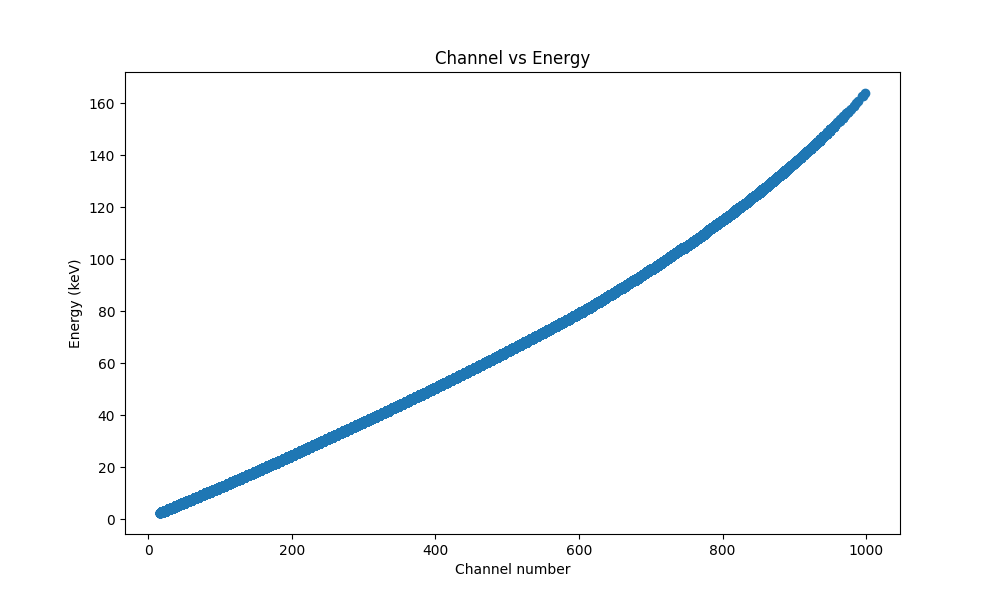

Text(0.5, 1.0, 'Channel vs Energy')

In [54]:
plt.scatter(data['Channel'],data['Energy'])
plt.xlabel('Channel number')
plt.ylabel('Energy (keV)')
plt.title('Channel vs Energy')

calibrating energy and cghannel usiung known decay source 
channel in which photon is detected (percentage of full voltage the electron has)

## EventLists from Stingray

We want to use the `EventList` class from Stingray because that gives us access to all the tools developed in Stingray. An `EventList` is basically the same data that we have above -- it is just a format translation.

In [13]:
evt = EventList(time = data['TIME'], 
                mjdref=hdulist[1].header['MJDREFI']
                +hdulist[1].header['MJDREFF'], 
                energy = data['Energy'])

The `EventList` class has many methods attached to it. Let's first calculate a lightcurve and plot it.

In [14]:
bin_time = 10# let's bin the data at 10 seconds (plotting lightcurve)
lc_10 = evt.to_lc(bin_time) #(to lightcurve)

The `Lightcurve` class basically has counts, count_rate, and the associated errors. We can use that to make a plot of the lightcurve.

<IPython.core.display.Javascript object>


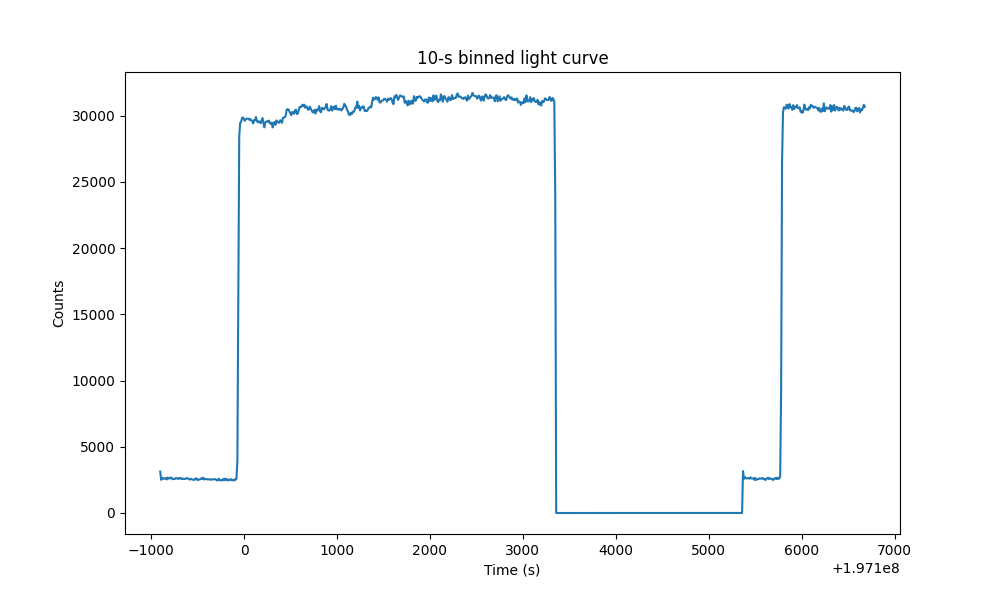

Text(0.5, 1.0, '10-s binned light curve')

In [36]:
plt.plot(lc_10.time, lc_10.counts)
plt.xlabel('Time (s)')
plt.ylabel('Counts')
plt.title('10-s binned light curve')


8000 sec data. orbital time of astrosat 90sec. going behind earth and observoing the crabb pulsar. taking only 3000 to 4000 range, therefore defining gti. 

Okay! What is happening here?
Why is the count rate suddenly increasing and decreasing?

We need to set a good time interval or GTI, which tells the analysis which time is useful and to be used for analysis. We will focus on data that came between 1000 seconds from the start of the observation to 4000 seconds from the start.

It is easiest to redefine the `evt` file.

In [15]:
tstart = hdulist[1].header['TSTART']
evt = EventList(time = data['TIME'], 
                mjdref=hdulist[1].header['MJDREFI']
                +hdulist[1].header['MJDREFF'], 
                energy = data['Energy'],
                gti=[[tstart+1000, tstart+4000]])

In [16]:
# remake the lightcurve
bin_time = 10. # let's bin the data at 10 seconds
lc_10 = evt.to_lc(bin_time)

<IPython.core.display.Javascript object>


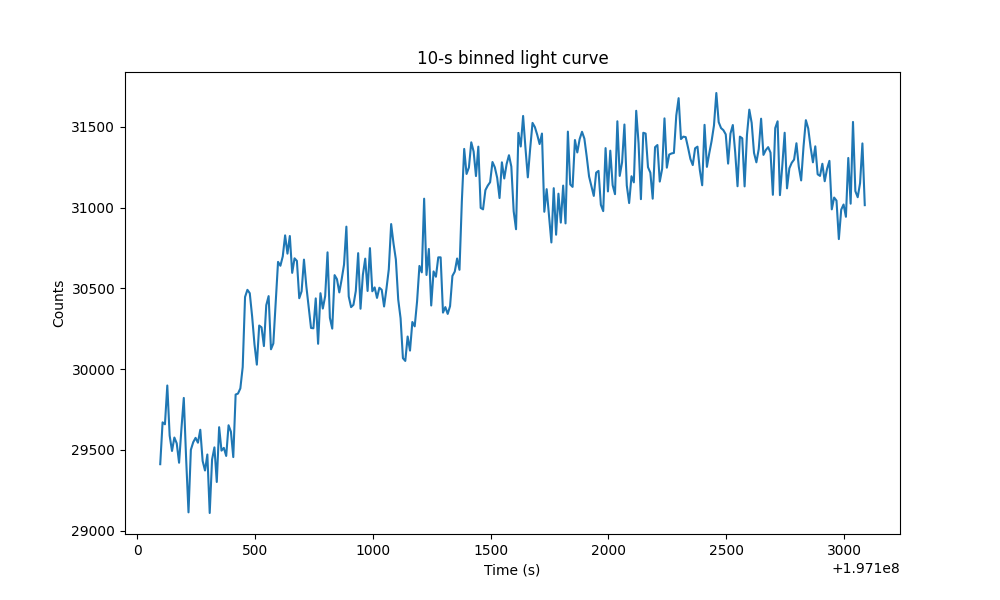

Text(0.5, 1.0, '10-s binned light curve')

In [40]:
plt.plot(lc_10.time, lc_10.counts)
plt.xlabel('Time (s)')
plt.ylabel('Counts')
plt.title('10-s binned light curve') # 2000 counts across 3000 variablees

Okay, this looks better. Now lets make a finer lightcurve. We'll use data at 1 millisecond (0.001 seconds).

In [23]:
bin_time = 0.001
lc_1ms = evt.to_lc(bin_time)

<IPython.core.display.Javascript object>


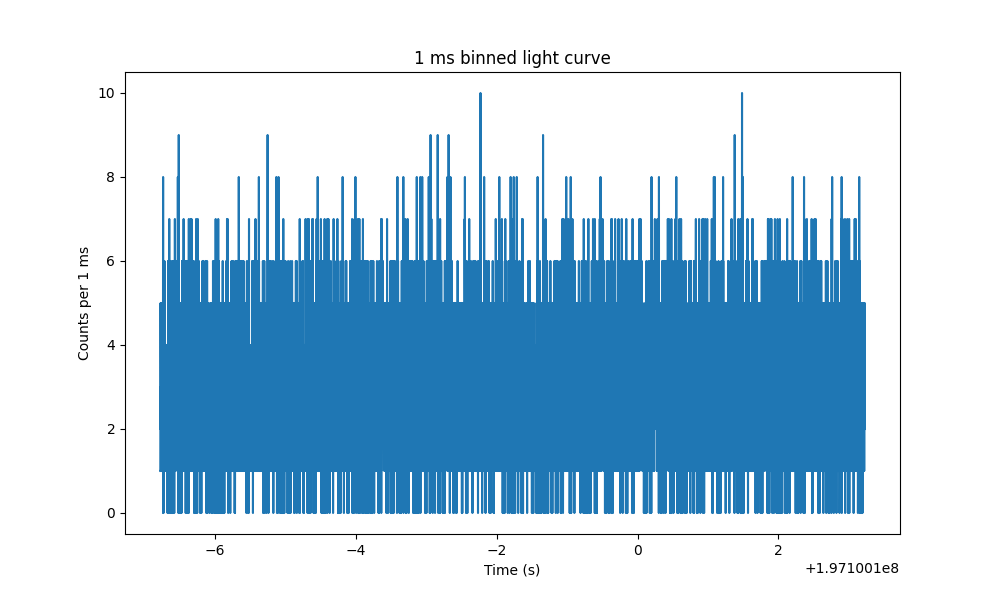

Text(0.5, 1.0, '1 ms binned light curve')

In [24]:
plt.plot(lc_1ms.time[:10000], lc_1ms.counts[:10000])
plt.xlabel('Time (s)')
plt.ylabel('Counts per 1 ms')
plt.title('1 ms binned light curve') # we get 0 12 photons

## Finding a period

Now we start the process of finding a period in this data.

We can first take a fourier transform and measure the absolute power to get a powerspectrum. The highest frequency that we can probe is determined by the binning of the lightcurve. 1 ms binning --> 500 Hz

<IPython.core.display.Javascript object>


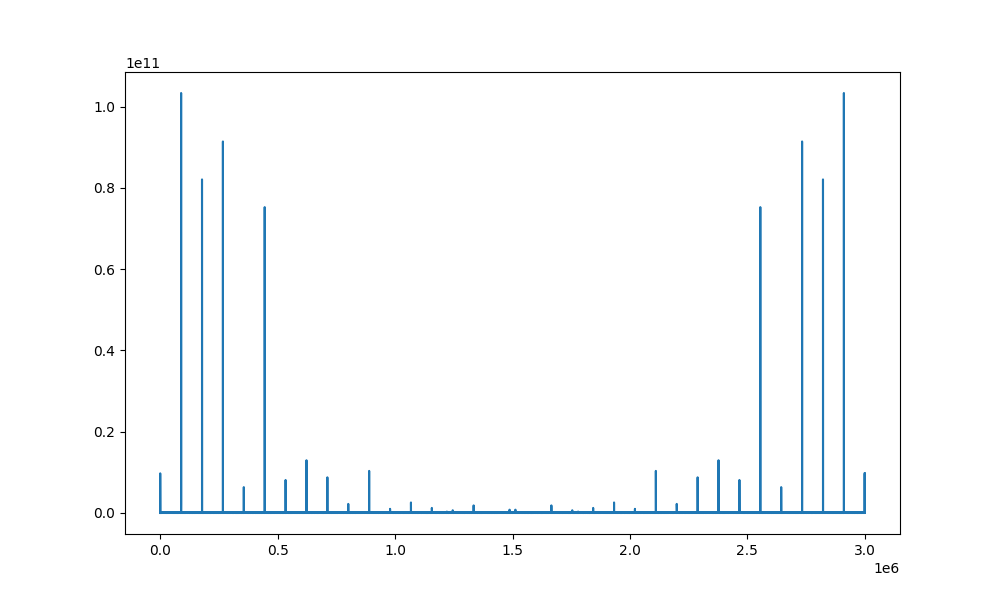

In [30]:
powerspec = np.abs(fft(lc_1ms.counts - np.mean(lc_1ms.counts)))**2 # make the data zero mean before FFT (subtracting zero frequency part)
plt.plot(powerspec) #symmetric data, therefore using half the data

<IPython.core.display.Javascript object>


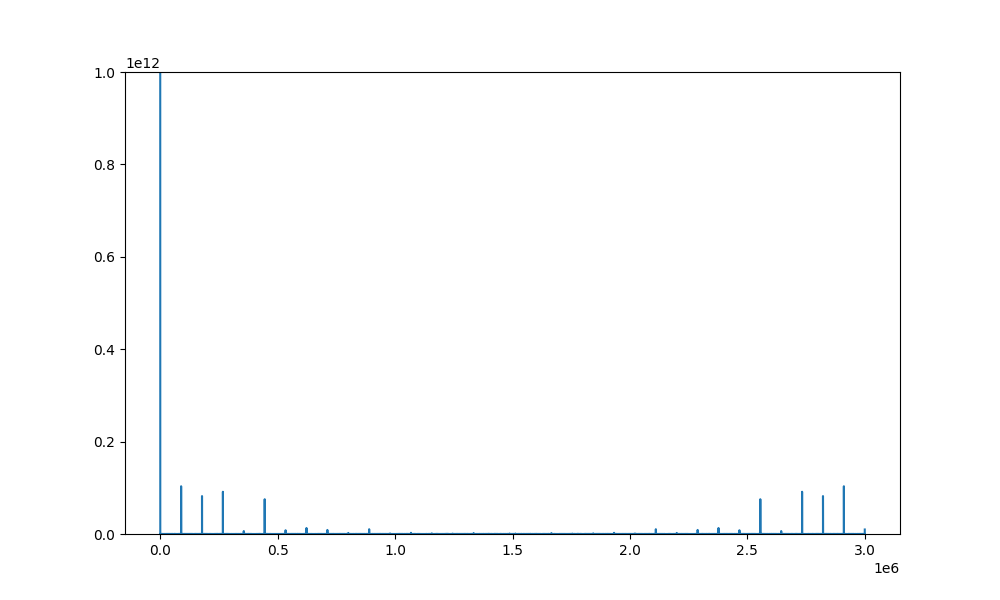

<function matplotlib.pyplot.show(block=None)>

In [52]:
powerspec = np.abs(fft(lc_1ms.counts))**2 # make the data zero mean before FFT (subtracting zero frequency part)
plt.ylim(0,1e11)
plt.plot(powerspec)
plt.show

measuring waveform (sine wave), around time period we get constant value.
Niquis sampling theorem

<IPython.core.display.Javascript object>


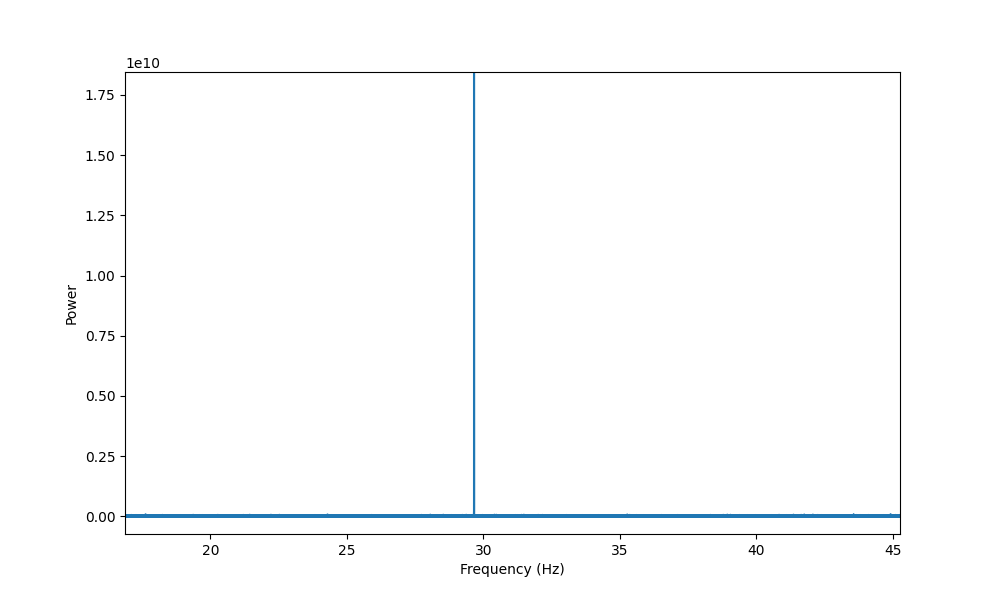

Text(0, 0.5, 'Power')

In [63]:
f_max = 1/(2*bin_time) # Nyquist frequency
n_bins = lc_1ms.n
df = 2*f_max/n_bins

powerspec = np.abs(fft(lc_1ms.counts - np.mean(lc_1ms.counts)))**2 # make the data zero mean before FFT (subtracting zero frequency part)

freqs = np.arange(0,f_max, df)

plt.plot(freqs, powerspec[0:int(n_bins/2)])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

fundamental frequency=29.6 hz ( from zoomed graph)

In [66]:
bins = lc_1ms.n
print(bins) #rotating 30 times every sec, need precise peaks

3000000


Zoom in to the power spectrum to see the noise. The peaks are far higher than the noise, but that's because this is a very bright pulsar.

Now, it is time to identify the peak frequencies.
We'll use `find_peaks` from scipy.

In [67]:
peaks, properties = find_peaks(powerspec[0:int(n_bins/2)], height=2E10) #height seemn from graph, just tells maxima of thre peak 

Identify the frequencies and periods associated with these peaks.

In [68]:
freqs[peaks] # in Hz

array([ 29.65533333,  59.31066667,  88.96633333, 148.277     ])

In [57]:
periods = 1/freqs[peaks]

In [58]:
periods # in seconds

array([0.03372075, 0.01686037, 0.01124021, 0.00674413])

##Now which is the correct period?
How do we determine which of these is the correct period/frequency?
Let's try folding the data at different frequencies.
folding the data (fold events)

In [101]:
fold_events? 

SyntaxError: invalid syntax (4112305315.py, line 1)

In [102]:
phase1, profile1, profile_err1 = fold_events(evt.time, freqs[peaks][2], nbin=100, gti=evt.gti)

In [93]:
phase2, profile2, profile_err2 = fold_events(evt.time, freqs[peaks][1], nbin=100, gti=evt.gti)

In [ ]:
phase, profile, profile_err = fold_events(evt.time, freqs[peaks][1]/2, nbin=100, gti=evt.gti)

In [94]:
#phase #0 to 1, 16 bins

<IPython.core.display.Javascript object>


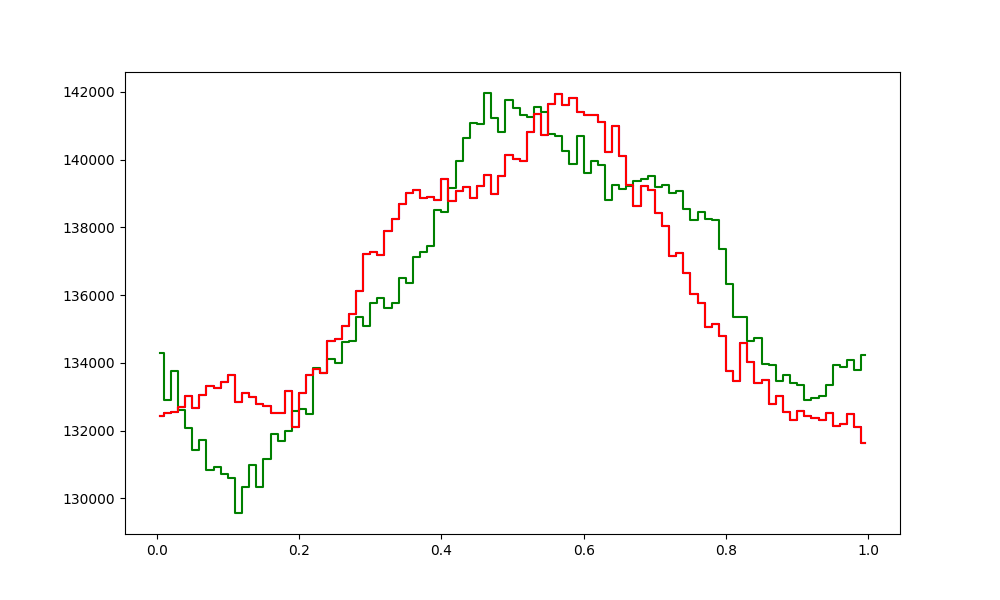

In [119]:
plt.plot(phase1,profile1,  drawstyle='steps-mid', color='blue') #harmonics
plt.plot(phase2, profile2,  drawstyle='steps-mid', color='green')
plt.plot(phase, profile ,drawstyle='steps-mid', color='red')

<IPython.core.display.Javascript object>


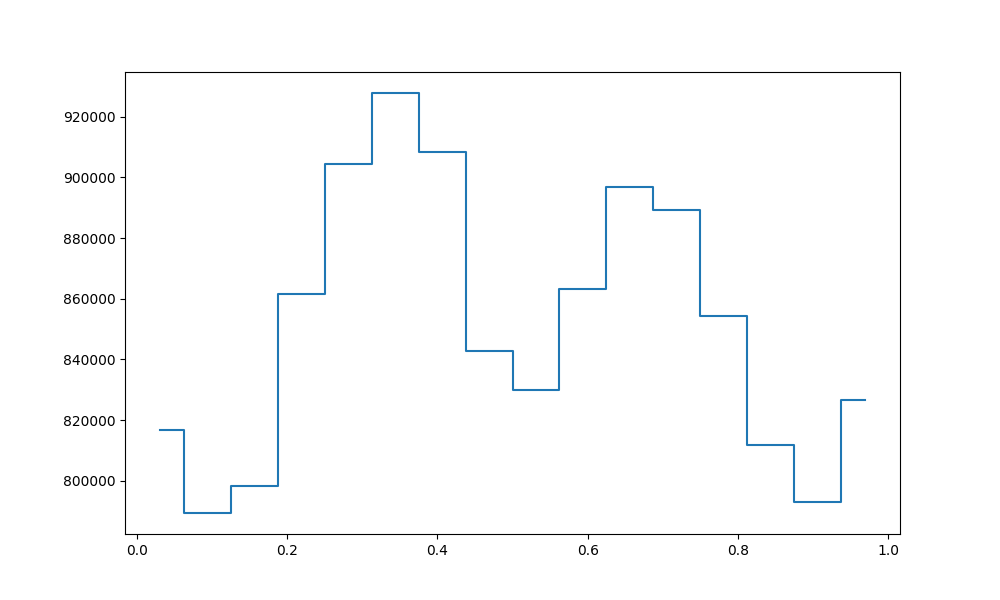

In [74]:
plt.plot(phase, profile, drawstyle='steps-mid') # folded light curve

In [108]:
f_max = 1/(2*bin_time) # Nyquist frequency
n_bins = lc_1ms.n
df = f_max/n_bins

powerspec = np.abs(fft(lc_1ms.counts - np.mean(lc_1ms.counts)))**2 # make the data zero mean before FFT (subtracting zero frequency part)

freqs = np.arange(0,f_max/2, df)

<IPython.core.display.Javascript object>


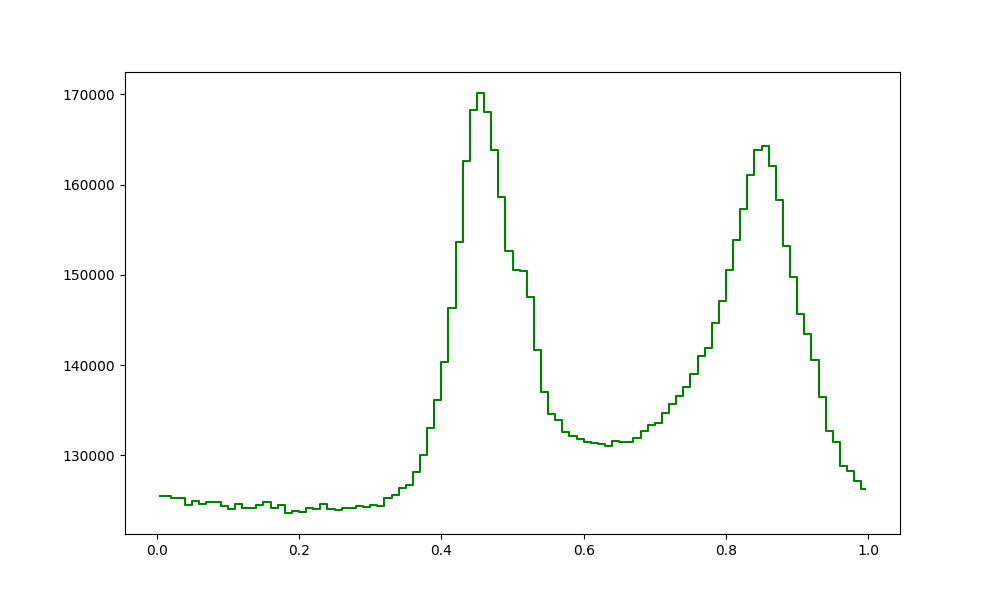

In [121]:
phase2, profile2, profile_err2 = fold_events(evt.time, freqs[peaks][1]+df/2, nbin=100, gti=evt.gti)
plt.plot(phase2, profile2,  drawstyle='steps-mid', color='green')